In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import format_number, mean, min, max, corr, stddev
from pyspark.sql.functions import (dayofmonth, hour, dayofyear, month, year, weekofyear, format_number, date_format, asc, desc)
from pyspark.sql.functions import explode, col, element_at, size, split
from pyspark.sql.functions import udf
import numpy as np
import matplotlib.pyplot as plt
#https://www.data4v.com/tutorial-hierarchical-clustering-in-spark-with-bisecting-k-means/

In [2]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans, BisectingKMeans


In [3]:
spark = SparkSession.builder \
    .appName('bisectingK') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','8g') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

In [4]:
data_path = "/papers_2000/abs/"

In [5]:
# Dummy table created ny AL_read_papers notebook
# Original data is first 30000 papers from 2010 with 50 assigned keywords
paps = spark.read.json("../data/processed/"+data_path+"/dummy/")

In [6]:
#Adding an ID to each paper so the abstract data analysis can be attributed to a paper
from pyspark.sql.functions import monotonically_increasing_id
papersWIDs = paps.withColumn("id", monotonically_increasing_id())
# remving nans
print(papersWIDs.count())
papersWIDs_woNA = papersWIDs.dropna()
print(papersWIDs_woNA.count())
papersWIDs_woNA_woNone = papersWIDs_woNA.filter("None == 0")
print(papersWIDs_woNA_woNone.count())

7192
7141
5303


In [7]:
from pyspark.sql.functions import col, log, lit

In [8]:
def log_transform(data, column_name):
    return data.withColumn("log_"+column_name,  log(lit(1) + col(column_name)))

In [9]:
data = papersWIDs_woNA_woNone
# data = log_transform(data, "citation_count")
# data = log_transform(data, "number_of_pages")
# data = log_transform(data, "num_refs")
data = data.dropna()
data.count()

5303

Included all columns except title and ID since those are strings and identifiers

In [10]:
from pyspark.ml.feature import VectorAssembler
assemble=VectorAssembler(
    #inputCols=[c for c in data.columns if not c in ['id', 'title', 'citation_count', 'number_of_pages', 'num_refs']],
    inputCols=[c for c in data.columns if not c in ['id', 'title', 'citation_count']],
    # inputCols=[c for c in data.columns if not c in ['id', 'title']],
    outputCol='features')
assembled_data=assemble.transform(data)
#assembled_data.show(2)

In [11]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
scaled_data=data_scale.transform(assembled_data)
#data_scale_output.show(2)

In [12]:
scaled_data.count()

5303

# Fit the model

In [13]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [50]:
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette')
print("["+("".join(["."]*len(range(2,50))))+"]")
print("[", end="")
for K in range(2,50):
    print(".", end="")
    KMeans_=KMeans(featuresCol='features', k=K)
    KMeans_fit=KMeans_.fit(scaled_data)
    KMeans_transform=KMeans_fit.transform(scaled_data) 
    evaluation_score=evaluator.evaluate(KMeans_transform)
    silhouette_scores.append(evaluation_score)
silhouette_scores_array = np.array([[k, s] for k, s in zip(range(2,50), silhouette_scores)])

[................................................]
[................................................

In [51]:
Lcost = []
print("".join(["["]+[" "]*(50-2)+["]"]))
print("[", end="")
for k in range(2, 50):
    model = KMeans(
        featuresCol='features', k=k, seed = k).fit(scaled_data)
    cost = model.summary.trainingCost
    Lcost = Lcost + [[k, cost]]
    print(".", end="")
print("]")
Lcost_array = np.array(Lcost)

[                                                ]
[................................................]


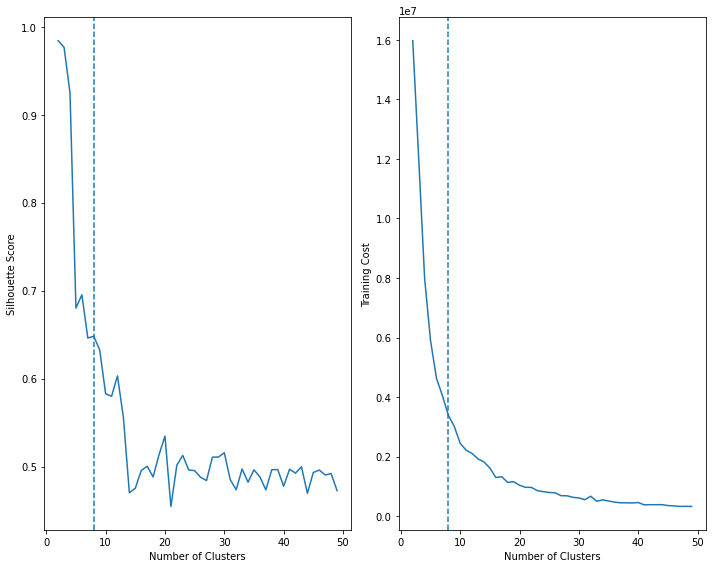

In [52]:
import matplotlib.pyplot as plt
def make_plot(data, y_label, ax, k0):
    ax.plot(data[:,0], data[:,1])
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel(y_label)
    ax.axvline(x=k0, linestyle='--')
k0 = 8
fig, ax = plt.subplots(1,2, figsize =(10,8))
make_plot(data=silhouette_scores_array, y_label='Silhouette Score', ax=ax[0], k0=k0)
make_plot(data=Lcost_array, y_label='Training Cost', ax=ax[1], k0=8)
plt.tight_layout()

The predictions seem pretty stable. With k=1  clusters' sizes and centroid positions do not depend strongly on the seed

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [16]:
k0 = 8
for seed in range(10):
    KMeans_= KMeans(featuresCol='features', k=k0, seed = seed)
    KMeans_Model=KMeans_.fit(assembled_data)
    KMeans_transform=KMeans_Model.transform(assembled_data)
    print("seed=", seed, "\t",
        list(KMeans_Model.summary.predictions.groupby("prediction").count().sort(desc("count")).toPandas()["count"]),
        "\t",
        [round(C[0],2) for C in KMeans_Model.clusterCenters()]
    )

seed= 0 	 [3084, 2271, 497, 57, 41, 16, 5, 1] 	 [0.11, 0.0, 0.08, 0.38, 0.18, 0.24, 0.4, 0.17]
seed= 1 	 [3704, 1945, 242, 42, 34, 3, 1, 1] 	 [0.08, 0.0, 0.29, 0.24, 0.12, 0.0, 0.33, 0.19]
seed= 2 	 [3614, 1999, 266, 42, 33, 13, 4, 1] 	 [0.12, 0.25, 0.38, 0.08, 0.24, 0.0, 0.24, 0.17]
seed= 3 	 [3614, 1992, 271, 42, 34, 16, 2, 1] 	 [0.24, 0.08, 0.38, 0.21, 0.5, 0.0, 0.12, 0.17]
seed= 4 	 [2616, 2291, 826, 149, 46, 34, 9, 1] 	 [0.08, 0.1, 0.24, 0.0, 0.28, 0.14, 0.33, 0.17]
seed= 5 	 [3703, 1916, 237, 39, 33, 31, 12, 1] 	 [0.08, 0.0, 0.18, 0.24, 0.23, 0.18, 0.12, 0.42]
seed= 6 	 [4383, 1467, 61, 41, 14, 3, 2, 1] 	 [0.09, 0.33, 0.43, 0.18, 0.13, 0.0, 0.22, 0.5]
seed= 7 	 [2412, 2317, 992, 170, 41, 34, 5, 1] 	 [0.14, 0.0, 0.2, 0.29, 0.07, 0.1, 0.24, 0.18]
seed= 8 	 [3084, 2271, 497, 57, 41, 16, 5, 1] 	 [0.17, 0.38, 0.08, 0.24, 0.4, 0.0, 0.11, 0.18]
seed= 9 	 [2631, 2298, 811, 151, 42, 34, 4, 1] 	 [0.17, 0.1, 0.0, 0.25, 0.15, 0.29, 0.24, 0.08]


Here are mean citation counts per clusters

In [14]:
from pyspark.sql.functions import stddev, count as _count, lit

KMeans_Model = KMeans(featuresCol='features', k=8, seed = 3).fit(assembled_data)
tab = KMeans_Model.summary.predictions.\
    groupby("prediction").agg(
        mean("citation_count").alias("mean"),
        # stddev("citation_count").alias("sigma"),
        _count(lit(1)).alias("count")
    ).\
    select(col("prediction").alias("cluster"), col("count"), col("mean").cast("int")).\
    sort(asc("count"))
tab

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


cluster,count,mean
1,1,20
2,1,232
3,5,3
5,24,371
7,56,139
4,438,112
6,1965,59
0,2813,26


In [15]:
print(tab.toPandas().to_latex(index = False))

\begin{tabular}{rrr}
\toprule
 cluster &  count &  mean \\
\midrule
       1 &      1 &    20 \\
       2 &      1 &   232 \\
       3 &      5 &     3 \\
       5 &     24 &   371 \\
       7 &     56 &   139 \\
       4 &    438 &   112 \\
       6 &   1965 &    59 \\
       0 &   2813 &    26 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_28512/2569547265.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tab.toPandas().to_latex(index = False))


In [17]:
results  = KMeans_Model.summary.predictions

numeric_columns = [c[0] for c in results.dtypes if c[1] == "bigint" and not c[0] in ["id", "None", "citation_count"]]

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [20]:
C_1 = results.filter("prediction == 5").select(numeric_columns).describe().filter("summary == 'mean'").\
    collect()[0].asDict()

C_2 = results.filter("prediction == 7").select(numeric_columns).describe().filter("summary == 'mean'").\
    collect()[0].asDict()

In [21]:
import pandas as pd
pd.DataFrame([C_1, C_2])

,summary,chiral,corrections,decay,decays,effects,gauge,higgs,masses,mixing,...,number_of_pages,obtained,quark,results,scalar,scattering,shown,supersymmetric,symmetry,using
0,mean,0.16666666666666666,0.125,0.08333333333333333,0.041666666666666664,0.20833333333333334,0.16666666666666666,0.0,0.16666666666666666,0.041666666666666664,...,145.08333333333334,0.0,0.375,0.375,0.041666666666666664,0.16666666666666666,0.0,0.20833333333333334,0.125,0.08333333333333333
1,mean,0.08928571428571429,0.16071428571428573,0.17857142857142858,0.10714285714285714,0.21428571428571427,0.08928571428571429,0.0,0.125,0.07142857142857142,...,123.92857142857143,0.07142857142857142,0.30357142857142855,0.26785714285714285,0.08928571428571429,0.08928571428571429,0.05357142857142857,0.10714285714285714,0.17857142857142858,0.10714285714285714


In [17]:
tab.toPandas().to_csv("../data/processed/"+data_path+"/kmeans_mean_table.csv")

Let us do some visuals. PCA is very usefull for this

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


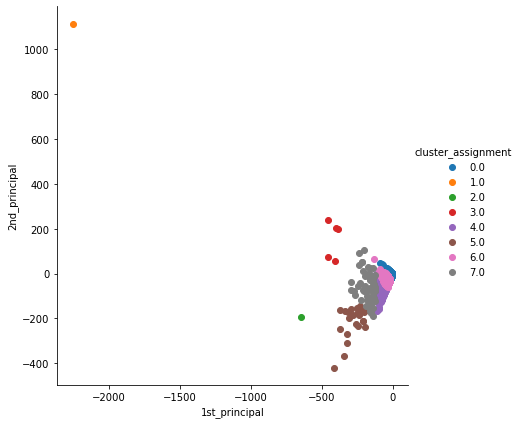

In [22]:
from pyspark.ml.feature import PCA as PCAml
KMeans_transform = KMeans_Model.summary.predictions
pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(KMeans_transform)

import numpy as np
X_pca = pca_transformed.rdd.map(lambda row: row.pca).collect()
X_pca = np.array(X_pca)


cluster_assignment = np.array(KMeans_transform.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pca_data = np.hstack((X_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()
# plt.xlim(0, 750)
# plt.ylim(-500, 1000)
plt.savefig("../data/processed/"+data_path+"/kmeans_pca.pdf")

In [23]:
data_path

'/papers_2000/kws/'

The clustering is evident

In [22]:
np.savetxt("../data/processed/"+data_path+"/kmeans_silhouette_scores_array.txt", silhouette_scores_array)
np.savetxt("../data/processed/"+data_path+"/kmeans_Lcost.txt", Lcost_array)

KMeans_transform.write.mode("overwrite").json("../data/processed/"+data_path+"/KMeans/")